# Experiment-3: Recommendation System Based on Matrix Factorization
## In this experiment, we will: 
- (1) Get more intuitions about Matrix Decomposition. 
- (2) Get your hands dirty on MovieLens-100k dataset, which contains 10,000 comments from 943 users out of 1682 movies. 
- (3) Get some intuition about hidden dimension's impact.
- (4) Get some intuition about loss function's impact.
- (5) Get some intuition about regularizer's impact.
### As usual, in this experiment, we will use the mini framework [simple_ml](https://github.com/lizhaoliu-Lec/simple_ml).

In [1]:
# as usual, do a little setup
%pip install simple_machine_learning
import os
import random
import pickle
import numpy as np

from tqdm import tqdm
from PIL import Image

from sklearn.tree import DecisionTreeClassifier
from simple_ml.preprocessing import NPDFeature
from simple_ml.ensemble import AdaBoostClassifier

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.


In [2]:
# load the data.

def convert_data_to_npd_feats(data_path='..\\tmp\\exp3', size=24, val_split=0.1, test_split=0.2, seed=1234):
    face_img_root = os.path.join(data_path, 'face')
    non_img_root = os.path.join(data_path, 'nonface')
    faces_img_paths = os.listdir(face_img_root)
    non_img_paths = os.listdir(non_img_root)
    faces_img_paths = [os.path.join(face_img_root, i) for i in faces_img_paths]
    non_img_paths = [os.path.join(non_img_root, i) for i in non_img_paths]

    root_name = 'x'.join([str(size), str(size)])
    root_name = 'npd_' + root_name
    root_path = os.path.join(data_path, root_name)
    if not os.path.exists(root_path):
        os.makedirs(root_path)
    all_Xy_data_path = os.path.join(root_path, 'data.bin')

    if not os.path.exists(all_Xy_data_path):
        # get face images
        face_imgs = []
        for face_img in tqdm(faces_img_paths):
            im = Image.open(face_img, mode='r').convert('L')
            im = im.resize((size, size), Image.ANTIALIAS)
            im = np.asarray(im)
            npd = NPDFeature(image=im)
            im = npd.extract()
            face_imgs.append(im)
        face_arrays = np.array(face_imgs)
        face_labels = np.ones((face_arrays.shape[0], 1))
        # get non face images
        non_imgs = []
        for non_img in tqdm(non_img_paths):
            im = Image.open(non_img, mode='r').convert('L')
            im = im.resize((size, size), Image.ANTIALIAS)
            im = np.asarray(im)
            npd = NPDFeature(image=im)
            im = npd.extract()
            non_imgs.append(im)
        non_arrays = np.array(non_imgs)
        non_labels = -1 * np.ones((non_arrays.shape[0], 1))

        X = np.concatenate([face_arrays, non_arrays], axis=0)
        y = np.concatenate([face_labels, non_labels], axis=0)

        rand_idx = [_ for _ in range(X.shape[0])]
        random.seed(seed)
        random.shuffle(rand_idx)
        X = X[rand_idx]
        y = y[rand_idx]
        total_size = X.shape[0]
        train_size = int(total_size * (1 - val_split - test_split))
        val_size = train_size + int(total_size * val_split)
        X_train, y_train = X[:train_size] / 255.0, y[:train_size]
        X_val, y_val = X[train_size:val_size] / 255.0, y[train_size:val_size]
        X_test, y_test = X[val_size:] / 255.0, y[val_size:]
        pickle.dump([X_train, y_train, X_val, y_val, X_test, y_test],
                    file=open(all_Xy_data_path, mode='wb'))
    else:
        X_train, y_train, X_val, y_val, X_test, y_test = pickle.load(file=open(all_Xy_data_path, mode='rb'))
    print('X train: ', X_train.shape, ' y train: ', y_train.shape)
    print('X val: ', X_val.shape, ' y val: ', y_val.shape)
    print('X test: ', X_test.shape, ' y test: ', y_test.shape)
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = convert_data_to_npd_feats()
print('We have `%d` training examples, `%d` validation examples and `%d` test examples' % (X_train.shape[0], X_val.shape[0],X_test.shape[0]))
print('X_train shape: ', X_train.shape, ', X_val shape: ', X_val.shape, ', X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape, ', y_val shape: ', y_val.shape, ', y_test shape: ', y_test.shape)

X train:  (700, 165600)  y train:  (700, 1)
X val:  (100, 165600)  y val:  (100, 1)
X test:  (200, 165600)  y test:  (200, 1)
We have `700` training examples, `100` validation examples and `200` test examples
X_train shape:  (700, 165600) , X_val shape:  (100, 165600) , X_test shape:  (200, 165600)
y_train shape:  (700, 1) , y_val shape:  (100, 1) , y_test shape:  (200, 1)


We show the error rate to alpha in adaboost. 
We can see that, as the error rate goes up, alpha goes down.


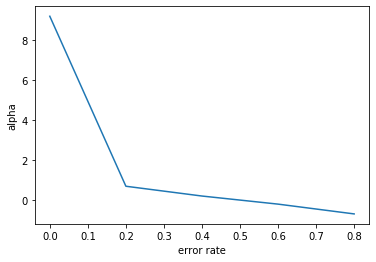

In [3]:
def error_to_alpha(x, eps=1e-8):
    x = x.clip(min=eps, max=1-eps)
    return 0.5 * np.log(1/x - 1)

z = np.arange(0, 1, 0.2)
e = error_to_alpha(z)
plt.plot(z, e)
plt.xlabel('error rate')
plt.ylabel('alpha')
# plt.savefig('loss_fn.png', dpi=300)
plt.show()


### Weak learner's Performance

We first evaluate the weak learner's performance with different depth in DTC.

We search depth in range(5) and validate the performance on validation set.

We can see that, as DTC become depper, DTC from underfitting to overfitting, and the best depth is 4, which achieve 89% accuracy in validation set.

********** begin with depth = 1 **********
********** begin with depth = 2 **********
********** begin with depth = 3 **********
********** begin with depth = 4 **********
********** begin with depth = 5 **********


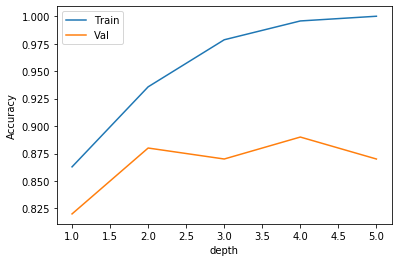

In validation set, best depth: 4, best accuracy: 0.8900


In [4]:
depths = [1, 2, 3, 4, 5]
d2train_acc = []
d2val_acc = []

for d in depths:
    print(10*'*' + ' begin with depth = %d ' % d + 10*'*')
    weak = DecisionTreeClassifier(max_depth=d)
    weak.fit(X_train, y_train)
    y_val_pred = weak.predict(X_val)
    y_train_pred = weak.predict(X_train)
    d2train_acc.append(accuracy(y_train, y_train_pred))
    d2val_acc.append(accuracy(y_val, y_val_pred))

plt.plot(depths, d2train_acc, label='Train')
plt.plot(depths, d2val_acc, label='Val')
plt.legend()
plt.xlabel('depth')
plt.ylabel('Accuracy')
plt.savefig('d_weak_acc.png', dpi=300)
plt.show()

max_idx = np.argmax(np.array(d2val_acc))
print('In validation set, best depth: %d, best accuracy: %.4f' % (depths[max_idx], d2val_acc[max_idx]) )


Now we explore the Adaboost's performance with different weak learner's performance.

We set Adaboost's number of weak learner to 5 due to computation limitation.

********** begin with depth = 1 **********


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:42<00:00, 20.58s/it]


********** begin with depth = 2 **********


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:07<00:00, 37.40s/it]


********** begin with depth = 3 **********


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:42<00:00, 56.45s/it]


********** begin with depth = 4 **********


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:46<00:00, 69.22s/it]


********** begin with depth = 5 **********


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:50<00:00, 70.17s/it]


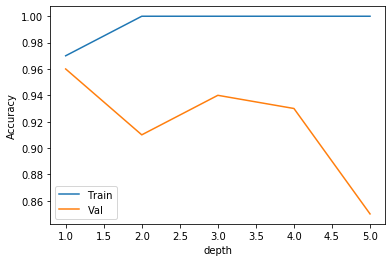

In validation set, best depth: 4, best accuracy of Adaboost: 0.8900


In [5]:
depths = [1, 2, 3, 4, 5]
d2train_acc_ad = []
d2val_acc_ad = []

number_of_weak_learner = 5

for d in depths:
    print(10*'*' + ' begin with depth = %d ' % d + 10*'*')
    weak = DecisionTreeClassifier(max_depth=d)
    ad = AdaBoostClassifier(weak, n_weakers_limit=number_of_weak_learner)
    ad.fit(X_train, y_train, X_val, y_val, early_stop=True)
    y_val_pred = ad.predict(X_val)
    y_train_pred = ad.predict(X_train)
    d2train_acc_ad.append(accuracy(y_train, y_train_pred))
    d2val_acc_ad.append(accuracy(y_val, y_val_pred))

plt.plot(depths, d2train_acc_ad, label='Train')
plt.plot(depths, d2val_acc_ad, label='Val')
plt.legend()
plt.xlabel('depth')
plt.ylabel('Accuracy')
plt.savefig('d_ad_acc.png', dpi=300)
plt.show()

max_idx = np.argmax(np.array(d2val_acc))
print('In validation set, best depth: %d, best accuracy of Adaboost: %.4f' % (depths[max_idx], d2val_acc[max_idx]) )

Now we compare the performance of DTC and Adaboost with 5 DTC under different DTC's depths setting.

depth: 1, DTC Acc_tr: 0.862857, AD Acc_tr: 0.970000, DTC Acc_val: 0.820000, AD Acc_val: 0.960000
depth: 2, DTC Acc_tr: 0.935714, AD Acc_tr: 1.000000, DTC Acc_val: 0.880000, AD Acc_val: 0.910000
depth: 3, DTC Acc_tr: 0.978571, AD Acc_tr: 1.000000, DTC Acc_val: 0.870000, AD Acc_val: 0.940000
depth: 4, DTC Acc_tr: 0.995714, AD Acc_tr: 1.000000, DTC Acc_val: 0.890000, AD Acc_val: 0.930000
depth: 5, DTC Acc_tr: 1.000000, AD Acc_tr: 1.000000, DTC Acc_val: 0.870000, AD Acc_val: 0.850000


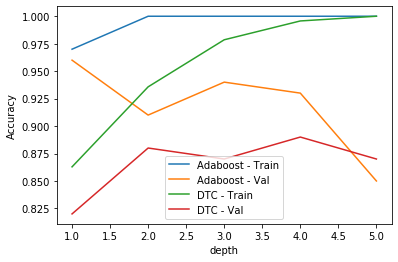

In [8]:
# print out the performance of DTC and Adaboost under different depth.

for d, dtc_tr, ad_tr, dtc_val, ad_val in zip(depths, d2train_acc, d2train_acc_ad, d2val_acc, d2val_acc_ad):
    print('depth: %d, DTC Acc_tr: %f, AD Acc_tr: %f, DTC Acc_val: %f, AD Acc_val: %f' % (d, dtc_tr, ad_tr, dtc_val, ad_val))
    
plt.plot(depths, d2train_acc_ad, label='Adaboost - Train')
plt.plot(depths, d2val_acc_ad, label='Adaboost - Val')
plt.plot(depths, d2train_acc, label='DTC - Train')
plt.plot(depths, d2val_acc, label='DTC - Val')
plt.legend()
plt.xlabel('depth')
plt.ylabel('Accuracy')
plt.savefig('d_acc.png', dpi=300)
plt.show()

### Number of weak learner exploration
In this section, we evaluate the performance of Adaboost as the number of weak learner goes up e.g. in range(1, 5).

We first set the depth of DTC to 1 due to computation limitation. 

********** begin with n = 1 **********


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.76s/it]


********** begin with n = 2 **********


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:40<00:00, 20.01s/it]


********** begin with n = 3 **********


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:00<00:00, 20.07s/it]


********** begin with n = 4 **********


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:30<00:00, 22.65s/it]


********** begin with n = 5 **********


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:42<00:00, 20.57s/it]


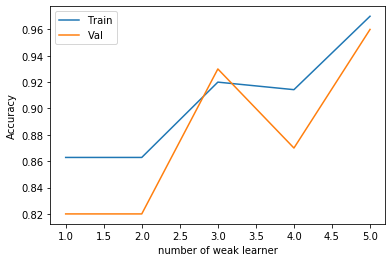

In [9]:
numbers_of_weak_learner = [1, 2, 3, 4, 5]
n2train_acc = []
n2val_acc = []

for n in numbers_of_weak_learner:
    print(10*'*' + ' begin with n = %d ' % n + 10*'*')
    weak = DecisionTreeClassifier(max_depth=1)
    ad = AdaBoostClassifier(weak, n_weakers_limit=n)
    ad.fit(X_train, y_train, X_val, y_val, early_stop=True)
    y_val_pred = ad.predict(X_val)
    y_train_pred = ad.predict(X_train)
    n2train_acc.append(accuracy(y_train, y_train_pred))
    n2val_acc.append(accuracy(y_val, y_val_pred))
    
plt.plot(numbers_of_weak_learner, n2train_acc, label='Train')
plt.plot(numbers_of_weak_learner, n2val_acc, label='Val')
plt.legend()
plt.xlabel('number of weak learner')
plt.ylabel('Accuracy')
plt.savefig('n_ad_acc.png', dpi=300)

Now we set the depth of DTC to from 1 to 5, and explore the performance of adaboost under different depth (1 to 5)'s settings.

In [3]:
numbers_of_weak_learner = [1, 2, 3, 4, 5]
depths = [1, 2, 3, 4, 5]
d2n2train_acc = []
d2n2val_acc = []

for d in depths:
    n2train_acc = []
    n2val_acc = []
    for n in numbers_of_weak_learner:
        print(10*'*' + ' begin with d = %d and n = %d ' % (d, n) + 10*'*')
        weak = DecisionTreeClassifier(max_depth=d)
        ad = AdaBoostClassifier(weak, n_weakers_limit=n)
        ad.fit(X_train, y_train, X_val, y_val, early_stop=True)
        y_val_pred = ad.predict(X_val)
        y_train_pred = ad.predict(X_train)
        n2train_acc.append(accuracy(y_train, y_train_pred))
        n2val_acc.append(accuracy(y_val, y_val_pred))
    d2n2train_acc.append(n2train_acc)
    d2n2val_acc.append(n2val_acc)
    

********** begin with d = 1 and n = 1 **********


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:22<00:00, 22.26s/it]


********** begin with d = 1 and n = 2 **********


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:38<00:00, 19.30s/it]


********** begin with d = 1 and n = 3 **********


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:57<00:00, 19.12s/it]


********** begin with d = 1 and n = 4 **********


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:17<00:00, 19.34s/it]


********** begin with d = 1 and n = 5 **********


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:36<00:00, 19.23s/it]


********** begin with d = 2 and n = 1 **********


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:35<00:00, 35.98s/it]


********** begin with d = 2 and n = 2 **********


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:11<00:00, 35.76s/it]


********** begin with d = 2 and n = 3 **********


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:46<00:00, 35.34s/it]


********** begin with d = 2 and n = 4 **********


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:22<00:00, 35.61s/it]


********** begin with d = 2 and n = 5 **********


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:57<00:00, 35.58s/it]


********** begin with d = 3 and n = 1 **********


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:51<00:00, 51.09s/it]


********** begin with d = 3 and n = 2 **********


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:43<00:00, 51.79s/it]


********** begin with d = 3 and n = 3 **********


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:33<00:00, 51.32s/it]


********** begin with d = 3 and n = 4 **********


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:25<00:00, 51.27s/it]


********** begin with d = 3 and n = 5 **********


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:13<00:00, 50.68s/it]


********** begin with d = 4 and n = 1 **********


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:59<00:00, 59.41s/it]


********** begin with d = 4 and n = 2 **********


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:05<00:00, 62.64s/it]


********** begin with d = 4 and n = 3 **********


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:08<00:00, 62.80s/it]


********** begin with d = 4 and n = 4 **********


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:13<00:00, 63.37s/it]


********** begin with d = 4 and n = 5 **********


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:19<00:00, 63.91s/it]


********** begin with d = 5 and n = 1 **********


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:06<00:00, 66.16s/it]


********** begin with d = 5 and n = 2 **********


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.23s/it]


********** begin with d = 5 and n = 3 **********


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:19<00:00, 66.58s/it]


********** begin with d = 5 and n = 4 **********


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:25<00:00, 66.25s/it]


********** begin with d = 5 and n = 5 **********


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:31<00:00, 66.31s/it]


TypeError: not all arguments converted during string formatting

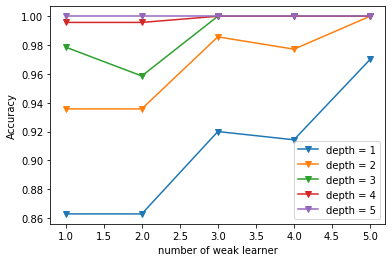

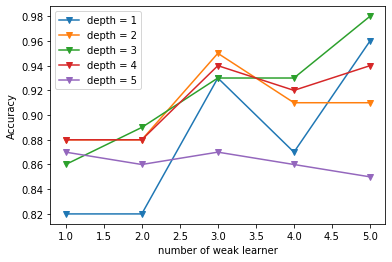

In [9]:
for idx, d in enumerate(depths):
    plt.plot(numbers_of_weak_learner, d2n2train_acc[idx], label='depth = %d' % d, marker='v')
plt.legend()
plt.xlabel('number of weak learner')
plt.ylabel('Accuracy')
plt.savefig('dn_ad_tr_acc.png', dpi=300)
plt.show()

for idx, d in enumerate(depths):
    plt.plot(numbers_of_weak_learner, d2n2val_acc[idx], label='depth = %d' % d, marker='v')
plt.legend()
plt.xlabel('number of weak learner')
plt.ylabel('Accuracy')
plt.savefig('dn_ad_val_acc.png', dpi=300)
plt.show()

### Final Performance
Now we get the final performance under best validation setting e.g. DTC's depth = 3 and number of weak learner = 5 in test set.

In [12]:
weak = DecisionTreeClassifier(max_depth=3)
ad = AdaBoostClassifier(weak, n_weakers_limit=5)
ad.fit(X_train, y_train, X_val, y_val, early_stop=True)
y_val_pred = ad.predict(X_val)
y_train_pred = ad.predict(X_train)
y_test_pred = ad.predict(X_test)
print('Best performnce: Training set: %.2f; Validation set: %.2f; Test set: %.2f ' % (accuracy(y_train, y_train_pred),
                                                                                      accuracy(y_val, y_val_pred),
                                                                                     accuracy(y_test, y_test_pred)))

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:52<00:00, 58.58s/it]


Best performnce: Training set: 1.00; Validation set: 0.98; Test set: 0.97 


###  Open-CV library for face detection

In [15]:
%run face_detection.py